# Freshwater anomaly

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import shapely
import geopandas as gpd
import salem
import cartopy

import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [4]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

### Load datasets

#### ECCOv4

In [5]:
eccov4 = xr.open_mfdataset('/mnt/efs/data/ecco/SALT/SALT.*.nc')

eccov4['i2'].values = eccov4.dep.values
eccov4['i3'].values = eccov4.lat.values[:,0]
eccov4['i4'].values = eccov4.lon.values[0,:]
eccov4 = eccov4.swap_dims({'i1':'tim'}).rename({'tim':'time','lat':'lat0','lon':'lon0',
                                                'i2':'depth','i3':'lat','i4':'lon',
                                                'SALT':'salinity'}).reset_coords().drop(['i1','dep','lat0','lon0'])

In [6]:
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_interp_area.nc')
eccov4['area'] = nc.area
eccov4.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

#### HadOBS EN4

In [7]:
hadobs = xr.open_dataset('/mnt/efs/data/hadobs/salinity.nc')

In [8]:
nc = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_area.nc')
hadobs['area'] = nc.area
hadobs.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

**LFWC**: Curry and Mauritzen (2005)

In [9]:
lfwc_spna_cm = pd.read_csv('/mnt/efs/data/Curry_and_Mauritzen_2005_fig02_fw_spna.csv',
                           header=None,names = ["time", "dF"])
lfwc_spna_cm.time = pd.DatetimeIndex(pd.date_range('1955-06-30','1995-06-30',freq='60M'))
lfwc_spna_cm.set_index(['time'],inplace=True)

In [10]:
lfwc_nsea_cm = pd.read_csv('/mnt/efs/data/Curry_and_Mauritzen_2005_fig02_fw_nsea.csv',
                           header=None,names = ["time", "dF"])
lfwc_nsea_cm.time = pd.DatetimeIndex(pd.date_range('1955-06-30','2000-06-30',freq='60M'))
lfwc_nsea_cm.set_index(['time'],inplace=True)

**LFWC**: ECCOv4 and HadOBS EN4

In [11]:
lfwc_spna_en_pentad = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_lfwc_spna_pentad.nc')
lfwc_spna_en_monthly = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_lfwc_spna_monthly.nc')
lfwc_spna_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/ecco_lfwc_spna_monthly.nc')

lfwc_nsea_en_pentad = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_lfwc_nsea_pentad.nc')
lfwc_nsea_en_monthly = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_lfwc_nsea_monthly.nc')
lfwc_nsea_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/ecco_lfwc_nsea_monthly.nc')

In [12]:
lfwc_spna_en = lfwc_spna_en_monthly.lfwc
lfwc_spna_en_anom = lfwc_spna_en - lfwc_spna_en.mean('time')

In [13]:
lfwc_spna_ec = lfwc_spna_ec_monthly.lfwc
lfwc_spna_ec_anom = lfwc_spna_ec - lfwc_spna_ec.mean('tim')

In [14]:
lfwc_nsea_en = lfwc_nsea_en_monthly.lfwc
lfwc_nsea_en_anom = lfwc_nsea_en - lfwc_nsea_en.mean('time')

In [15]:
lfwc_nsea_ec = lfwc_nsea_ec_monthly.lfwc
lfwc_nsea_ec_anom = lfwc_nsea_ec - lfwc_nsea_ec.mean('tim')

### Set spatial and temporal range

In [16]:
south,north,west,east = 40,90,-110,45

tstart = '1992-01-15'
tend = '2015-12-15'

In [17]:
psal_en = hadobs.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))
psal_ec = eccov4.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

### Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [18]:
psal_ref = 34.80

In [19]:
f_en = (psal_ref - psal_en)/psal_ref
f_ec = (psal_ref - psal_ec)/psal_ref

In [20]:
depth_bnds = hadobs.depth_bnds
dz = (depth_bnds[:,1]-depth_bnds[:,0])
h_fw_en = (f_en * dz).sum('depth')

In [21]:
f_ec

<xarray.DataArray 'salinity' (time: 287, depth: 50, lat: 100, lon: 310)>
dask.array<shape=(287, 50, 100, 310), dtype=float64, chunksize=(12, 50, 100, 310)>
Coordinates:
  * depth    (depth) float64 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
  * lat      (lat) float64 40.25 40.75 41.25 41.75 ... 88.25 88.75 89.25 89.75
  * lon      (lon) float64 -109.8 -109.2 -108.8 -108.2 ... 43.75 44.25 44.75
  * time     (time) datetime64[ns] 1992-01-16 1992-02-16 ... 2015-11-16

In [24]:
dz = xr.open_dataset('/mnt/efs/data/ecco/ecco_dz.nc').dz.rename({'dep':'depth'})

In [26]:
dz = xr.open_dataset('/mnt/efs/data/ecco/ecco_dz.nc').dz.rename({'dep':'depth'})
h_fw_ec = (f_ec * dz).sum('depth')

In [27]:
h_fw_en_annual = h_fw_en.groupby('time.year').mean('time')
h_fw_ec_annual = h_fw_ec.groupby('time.year').mean('time')

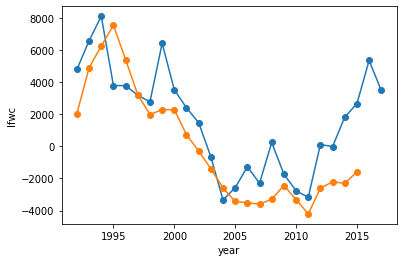

In [28]:
lfwc_spna_en_anom.groupby('time.year').mean('time').sel(year=slice(1992,2017)).plot(marker='o')
lfwc_spna_ec_anom.groupby('tim.year').mean('tim').plot(marker='o')

In [29]:
DeltaF_en = h_fw_en_annual.sel(year=2015) - h_fw_en_annual.sel(year=2011)
DeltaF_ec = h_fw_ec_annual.sel(year=2015) - h_fw_ec_annual.sel(year=2011)

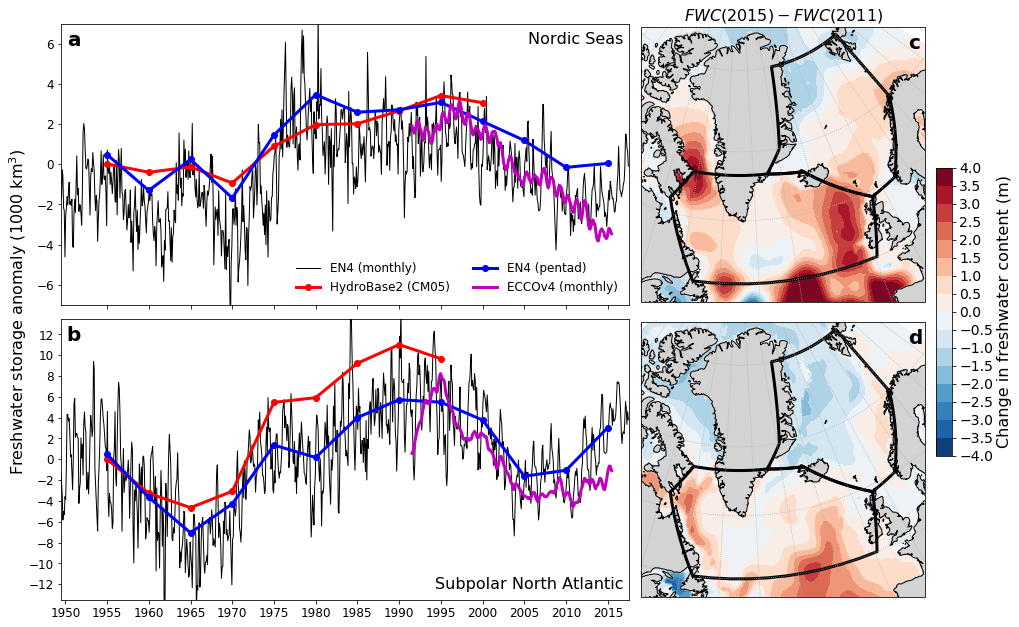

In [38]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05, wspace=0.03)
gs = gridspec.GridSpec(2, 2, height_ratios =[1,1], width_ratios =[2, 1])

axa = plt.subplot(gs[0,0])
axa.text(0.01,0.92, 'a', fontsize=20, fontweight='bold', transform=axa.transAxes)
axa.text(0.99,0.97, 'Nordic Seas', fontsize=16, ha='right', va='top', transform=axa.transAxes)
axa.plot(lfwc_nsea_en_anom.time, lfwc_nsea_en_anom*1e-3,lw=1,color='k',linestyle='-',label='EN4 (monthly)')
axa.plot(lfwc_nsea_cm.index, lfwc_nsea_cm.dF*1e-3,lw=3,color='r',linestyle='-',marker='o', label='HydroBase2 (CM05)')
axa.plot(lfwc_nsea_en_pentad.time, lfwc_nsea_en_pentad.lfwc*1e-3, lw=3, color='b', linestyle='-',marker='o', 
         label='EN4 (pentad)')
axa.plot(lfwc_nsea_ec_anom.tim, lfwc_nsea_ec_anom*1e-3, lw=3, color='m',linestyle='-',label='ECCOv4 (monthly)')
axa.set_xlim(['1950-01-01','2017-12-31'])
axa.set_ylim([-7,7])
axa.set_xticks(pd.date_range('1955-06-30','2015-06-30',freq='60M'))
axa.set_yticks(np.arange(-6,8,2))
axa.tick_params(axis = 'both', which = 'major', labelsize = 12)
axa.set_xticklabels([])
for tl in axa.get_yticklabels():
    tl.set_color('k')
axa.legend(loc='upper left',frameon=False, fontsize=14)
axa.legend(frameon=False, fontsize=12, loc='lower right', ncol=2)

axc = plt.subplot(gs[0,1], projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
axc.text(0.94,0.92, 'c', fontsize=20, fontweight='bold', transform=axc.transAxes)
axc.set_title(r'$FWC(2015) - FWC(2011)$',fontsize=16)
axc.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
axc.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
axc.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = axc.gridlines(linestyle=":", draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
gl_labels = axc.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, alpha=0.0)
gl_labels.xlocator = mticker.FixedLocator([-70, -60, -50, -40, -30, -20])
gl_labels.ylocator = mticker.FixedLocator([40, 50, 60, 70])
gl_labels.rotate_labels = False
gl_labels.top_labels = False
gl_labels.right_labels = False
gl_labels.bottom_labels = False
gl_labels.xlabel_style= {'size': 12, 'color': 'k'}
gl_labels.ylabel_style= {'size': 12, 'color': 'k'}
p = axc.contourf(DeltaF_en.lon,DeltaF_en.lat,np.clip(DeltaF_en,-4,4),cmap='RdBu_r',
                 vmin=-4,vmax=4,levels = np.arange(-4,4.5,0.5),
                 transform=cartopy.crs.PlateCarree())
axc.add_geometries([gdf_nsea['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                   linewidth=3, linestyle='-')
axc.add_geometries([gdf_spna['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                   linewidth=3, linestyle='-')

axb = plt.subplot(gs[1,0])
axb.text(0.01,0.92, 'b', fontsize=20, fontweight='bold', transform=axb.transAxes)
axb.text(0.99,0.03, 'Subpolar North Atlantic', fontsize=16, ha='right', va='bottom', transform=axb.transAxes)

axb.plot(lfwc_spna_en_anom.time,lfwc_spna_en_anom*1e-3,lw=1,color='k',linestyle='-',label='EN4 (monthly)')
axb.plot(lfwc_spna_cm.index,lfwc_spna_cm.dF*1e-3, lw=3,color='r',linestyle='-',marker='o',label='HydroBase2 (CM05)')
axb.plot(lfwc_spna_en_pentad.time, lfwc_spna_en_pentad.lfwc*1e-3, lw=3, color='b', linestyle='-',marker='o', 
         label='EN4 (pentad)')
axb.plot(lfwc_spna_ec_anom.tim, lfwc_spna_ec_anom*1e-3, lw=3, color='m',linestyle='-',label='ECCOv4 (monthly)')
axb.set_xlim(['1950-01-01','2017-12-31'])
axb.set_ylim([-13.5,13.5])
axb.set_xticks(pd.date_range('1950-06-30','2015-06-30',freq='60M'))
axb.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axb.set_yticks(np.arange(-12,14,2))
axb.tick_params(axis = 'both', which = 'major', labelsize = 12)
for tl in axb.get_yticklabels():
    tl.set_color('k')
    
axd = plt.subplot(gs[1,1], projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
axd.text(0.94,0.92, 'd', fontsize=20, fontweight='bold', transform=axd.transAxes)
axd.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
axd.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
axd.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = axd.gridlines(linestyle=":", draw_labels=False)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
gl_labels = axd.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, alpha=0.0)
gl_labels.xlocator = mticker.FixedLocator([-70, -60, -50, -40, -30, -20])
gl_labels.ylocator = mticker.FixedLocator([40, 50, 60, 70])
gl_labels.rotate_labels = False
gl_labels.top_labels = False
gl_labels.right_labels = False
gl_labels.bottom_labels = False
gl_labels.xlabel_style= {'size': 12, 'color': 'k'}
gl_labels.ylabel_style= {'size': 12, 'color': 'k'}
p = axd.contourf(DeltaF_ec.lon,DeltaF_ec.lat,np.clip(DeltaF_ec,-4,4),cmap='RdBu_r',
                 vmin=-4,vmax=4,levels = np.arange(-4,4.5,0.5),
                 transform=cartopy.crs.PlateCarree())
axd.add_geometries([gdf_nsea['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                   linewidth=3, linestyle='-')
axd.add_geometries([gdf_spna['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                   linewidth=3, linestyle='-')

fig.text(0.05, 0.5, 'Freshwater storage anomaly (1000 km$^3$)', va='center', rotation='vertical',fontsize=16)
cax = fig.add_axes([0.91, 0.30, 0.015, 0.4])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.9, ticks=np.arange(-4,4.5,0.5))
cb.set_label(r'Change in freshwater content (m)',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.show()